# 1) 사전 준비   
- 모듈 다운   
pip install opencv-python
pip install cmake     
pip install dlib     

- 사진 다운   
[고양이 수염 이미지](https://www.flaticon.com/free-icon/cat-whiskers_24674?term=cat%20nose&page=1&position=1)

In [1]:
# 모듈 불러오기
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import os

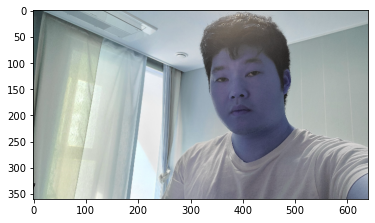

In [2]:
# 내 셀카 사진 불러오기
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image_me.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

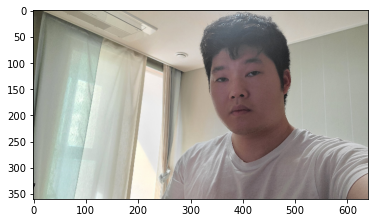

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

# 2) 얼굴 검출 & 랜드마크 검출
- 얼굴 검출

In [4]:
#dlib를 활용해 hog detector 선언
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

#detector를 이용해 얼굴의 bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(325, 96) (454, 225)]]


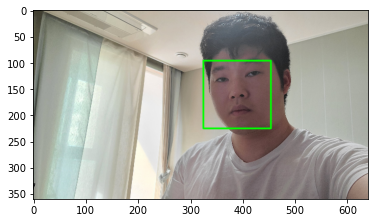

In [5]:
#찾은 얼굴 화면에 출력
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- 랜드마크 검출

In [6]:
#저장한 landmark 모델 불러오기
import dlib
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [7]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


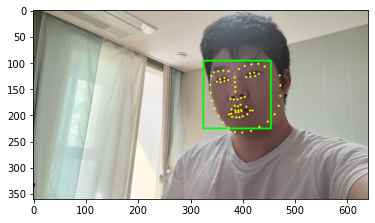

In [8]:
#랜드마크를 영상에 출력
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 3) 스티커 적용 위치 확인하기
[hint] 2, 36, 48, 30 번 인덱스를 이용    
- 수염사진의 중앙이 코 중앙인 33번에 위차하도록 위치 설정   
- top : x- w//2   
- left: y- h//2

In [9]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33]) # whiskers center index : 33
    x = landmark[33][0]
    y = landmark[33][1] 
    w =  dlib_rect.width()
    h =  dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(390, 170)
(x,y) : (390,170)
(w,h) : (130,130)


In [10]:
#고양이 수염 불러오기
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(130, 130, 3)


In [11]:
# top, left 위치 설정
refined_x = x - w//2 # left
refined_y = y - h//2   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (325,105)


# 4. 스티커 적용하기

In [12]:
sticker_area = img_show[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

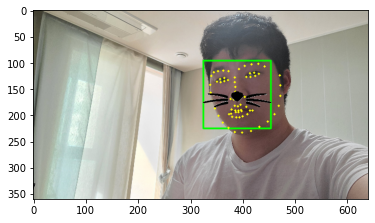

In [13]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- Bounding box, Landmark 제거

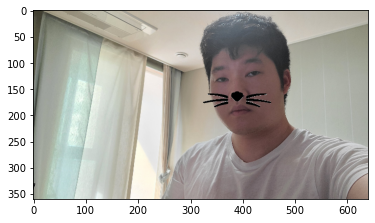

In [14]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

- 얼굴의 회전각도에 맞춰 회전하지 않아 어색한 고양이가 되었다...

# 5) 문제점 찾아보기   
- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?   
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?   
- 실행 속도가 중요할까요?   
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?   

In [15]:
def test_sticker(img_path):
    #이미지 로드
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/' + img_path
    img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
    img_bgr = cv2.resize(img_bgr, (640, 360)) 
    img_show = img_bgr.copy()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

    #detector를 이용해 얼굴의 bounding box 추출
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1) 
    
    # 얼굴 검출
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    #저장한 landmark 모델 불러오기

    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)    
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)        
    #스티커 적용위치
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # whiskers center index : 33
        x = landmark[33][0]
        y = landmark[33][1] 
        w =  dlib_rect.width()
        h =  dlib_rect.width()
    
    
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    # top, left 위치 설정
    refined_x = x - w//2 # left
    refined_y = y - h//2   # top

    
    sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

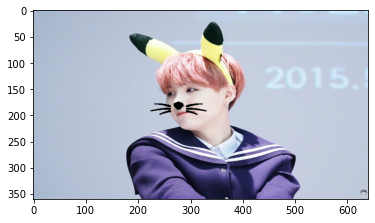

In [16]:
test_sticker('suga.jpg' )

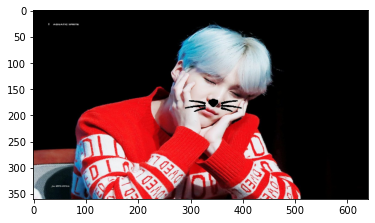

In [17]:
test_sticker('suga2.jpg' )

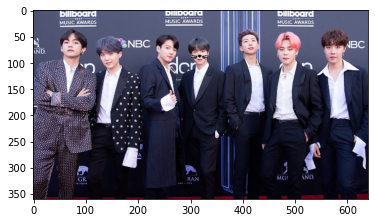

In [18]:
test_sticker('BTS.jpg' )

# 6) 결론   

- 얼굴 각도에 따라 스티커도 같이 회전하면 훨씬 자연스러울 것이다.   
- 멀리서 촬영하거나 모습이 변하면 그에 따라 스티커 크기나 모양도 변해야 할 것이다.   
- 실행속도는 상당히 빠르다. ( 사진 어플을 생각하면 당연히 빨라야 할 것이다)   
- 마지막 test를 보면 가운데에 '진' 밖에 인식을 못했다.  정확도의 중요성을 보여준다.

In [19]:
# def load_img(img):
#     my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/' + img
#     img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
#     img_bgr = cv2.resize(img_bgr, (640, 360)) 
#     img_show = img_bgr.copy()  
    
#     img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#     detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

#     #detector를 이용해 얼굴의 bounding box 추출
#     img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
#     dlib_rects = detector_hog(img_rgb, 1) 
#     print(dlib_rects)   # 찾은 얼굴영역 좌표

#     for dlib_rect in dlib_rects:
#         l = dlib_rect.left()
#         t = dlib_rect.top()
#         r = dlib_rect.right()
#         b = dlib_rect.bottom()

#     cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

#     img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
#     plt.imshow(img_show_rgb)
#     plt.show()